In [3]:
import warnings
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
warnings.filterwarnings("ignore", category=RuntimeWarning, module="pyogrio.raw")
warnings.filterwarnings("ignore", category=DeprecationWarning)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Load data
metro_buffer = gpd.read_file('data/Metro_One_Mile_Buffer_Py.shp')
metro_stations = gpd.read_file('data/Metro_Stations_Regional.shp')
muni_boundary = gpd.read_file('data/Municipal_Boundary_Py.shp')
property_gdf = gpd.read_file('data/Property_Info_Py.shp')

In [5]:
# Define CRS: EPSG 2248 (NAD83 / Maryland)
crs_projected = 2248  # Units in feet

# Reproject datasets to projected CRS
metro_buffer = metro_buffer.to_crs(epsg=crs_projected)
metro_stations = metro_stations.to_crs(epsg=crs_projected)
muni_boundary = muni_boundary.to_crs(epsg=crs_projected)
property_gdf = property_gdf.to_crs(epsg=crs_projected)

In [16]:
# --- Setup ---

# Prepare PG County metro one mile buffers
metro_union = metro_buffer.unary_union

# Select parcels fully within the metro one mile buffers
pg_metro_buffer = property_gdf[property_gdf.geometry.within(metro_union)].copy()

# Create 0.5 mile (2640 ft) buffer
def create_buffer(gdf, station_name):
    station = gdf[gdf['NAME'] == station_name]
    return station.geometry.buffer(2640).iloc[0]  # Return single shapely geometry

greenbelt_geom = create_buffer(metro_stations, 'Greenbelt')
cpumd_geom = create_buffer(metro_stations, 'College Park-U of Md')

# Get College Park city boundary
cp_geom = muni_boundary[muni_boundary['CITY'] == 'College Park'].geometry.unary_union

# Filter parcels by geometry
def filter_parcels(buffer_geom, city_geom=None):
    within_buffer = property_gdf[property_gdf.geometry.within(buffer_geom)]
    if city_geom is not None:
        return within_buffer[within_buffer.geometry.within(city_geom)]
    return within_buffer

greenbelt_cp = filter_parcels(greenbelt_geom, cp_geom)
cpumd_cp = filter_parcels(cpumd_geom, cp_geom)
cp_city = property_gdf[property_gdf.geometry.within(cp_geom)]

# --- Allowed Density Logic ---
def assign_allowed_density(row):
    # Normalize the input zone values
    zone_columns = ['ZONE_1', 'ZONE_2', 'ZONE_3', 'ZONE_4', 'ZONE_5']
    zone_values = [str(row[col]).upper() for col in zone_columns]
    land_use = str(row['LAND_USE']).upper()
    land_use_desc = str(row['LAND_USE_D']).upper()
    
    # Base Residential Zones
    base_zone_density = {
        'RE': 1.08,
        'RR': 2.17,
        'RSF-95': 4.58,
        'RSF-65': 6.7,
        'RSF-A': 32.6,
        'RMF-20': {
            'APARTMENT': 20.0, 'SUBSIDIZED': 20.0, 'CONDO': 20.0, 'VACANT': 20.0,
            'STANDARD': 14.0, 'SPLIT': 14.0, 'SUBDIVIDED': 14.0
        },
        'RMF-48': {
            'HI RISE': 48.0, 'APARTMENT': 48.0, 'GARDEN': 48.0, 'SUBSIDIZED': 48.0,
            'CONDO': 30.0, 'RETAIL/APT': 30.0, 'VACANT': 48.0
        },
        'RMF-12': 12.0
    }

    # TOD Zones (no conditional zoning — apply fixed residential max)
    tod_zone_density = {
        'NAC': 90.0,
        'TAC-C': 120.0,
        'TAC-E': 100.0,
        'LTO-C': 150.0,
        'LTO-E': 120.0,
        'RTO-L-C': 175.0,
        'RTO-L-E': 140.0,
        'RTO-H-C': 250.0,
        'RTO-H-E': 175.0
    }

    # Loop through all zone columns to check against base and TOD densities
    for zone in zone_values:
        if zone in base_zone_density:
            density = base_zone_density[zone]
            if isinstance(density, dict):
                # Check for land_use match and return corresponding density
                for key in density:
                    if key in land_use or key in land_use_desc:
                        return density[key]
                return None  # No match found for land_use
            return density
        
        elif zone in tod_zone_density:
            return tod_zone_density[zone]
    
    return None  # No matching zone found in any column

# Apply allowed/built density and underutilization
property_gdf['allowed_density'] = property_gdf.apply(assign_allowed_density, axis=1)
property_gdf = property_gdf.dropna(subset=['allowed_density']).copy()
property_gdf['built_density'] = property_gdf['DUS'] / property_gdf['ACRES']
property_gdf['underutilization_ratio'] = property_gdf['built_density'] / property_gdf['allowed_density']
property_gdf['underutilized'] = property_gdf['underutilization_ratio'] < 0.5

# --- Summary Function ---
def summarize(gdf, name):
    total_units = gdf['DUS'].sum()
    total_acres = gdf['ACRES'].sum()
    density = total_units / total_acres if total_acres > 0 else 0

    gdf = gdf.copy()
    gdf['allowed_density_temp'] = gdf.apply(assign_allowed_density, axis=1)
    gdf['weighted_allowed_density'] = gdf['allowed_density_temp'] * gdf['ACRES']
    total_allowed_density = gdf['weighted_allowed_density'].sum()
    total_acres_with_density = gdf['ACRES'][gdf['allowed_density_temp'].notnull()].sum()
    allowed_density = total_allowed_density / total_acres_with_density if total_acres_with_density > 0 else 0

    underutilized = gdf['underutilized'].sum()
    underutilization_ratio = gdf['underutilization_ratio'].mean()

    zone_counts = gdf['ZONE_1'].value_counts(dropna=False)
    zone_percent = (zone_counts / zone_counts.sum()) * 100
    zone_summary = (
        pd.DataFrame({'Count': zone_counts, 'Percent': zone_percent})
        .sort_values(by='Percent', ascending=False)
    )
    zone_summary['Percent'] = zone_summary['Percent'].map("{:.2f}".format)

    land_use = gdf['LAND_USE'].value_counts().reset_index(name='Count').rename(columns={'index': 'LAND_USE'})
    land_use_desc = gdf['LAND_USE_D'].value_counts().reset_index(name='Count').rename(columns={'index': 'LAND_USE_D'})

    sf = gdf[gdf['LAND_USE'] == 'Residential - Single Family'].copy()
    sf['DUS'] = pd.to_numeric(sf['DUS'], errors='coerce')
    sf['DUS_OWNER_'] = pd.to_numeric(sf['DUS_OWNER_'], errors='coerce')

    total_units_sf = sf['DUS'].sum()
    owner_occupied_units = sf['DUS_OWNER_'].sum()
    renter_occupied_units = total_units_sf - owner_occupied_units

    if total_units_sf > 0:
        owner_rate = owner_occupied_units / total_units_sf
        renter_rate = renter_occupied_units / total_units_sf
    else:
        owner_rate = renter_rate = float('nan')

    print(f"\n{name} Summary")
    print(f" - Total Units: {total_units:.2f}")
    print(f" - Total Acres: {total_acres:.2f}")
    print(f" - Built Density: {density:.2f} DUs/acre")
    print(f" - Allowed Density: {allowed_density:.2f} DUs/acre")
    print(f" - Underutilized Parcels: {underutilized:.0f}")
    print(f" - Underutilization Ratio (avg): {underutilization_ratio:.2f}")
    print(f" - Zoning Breakdown (ZONE_1):")
    print(zone_summary.to_string())
    print("\nLand Use Summary (LAND_USE):")
    print(land_use.to_string(index=False))
    print("\nLand Use Summary (LAND_USE_D):")
    print(land_use_desc.to_string(index=False))
    print("Residential - Single Family Summary")
    print(f" - Total Dwelling Units: {total_units_sf:.0f}")
    print(f" - Owner-Occupied Units: {owner_occupied_units:.0f} ({owner_rate:.1%})")
    print(f" - Renter-Occupied Units: {renter_occupied_units:.0f} ({renter_rate:.1%})")
    print()

# --- Run Summaries ---
summarize(pg_metro_buffer, "Prince George's County Metro One Mile Buffer")
summarize(cp_city, "City of College Park")
summarize(greenbelt_cp, "Greenbelt 0.5 Mile Buffer within College Park")
summarize(cpumd_cp, "College Park-U of Md 0.5 Mile Buffer within College Park")


Prince George's County Metro One Mile Buffer Summary
 - Total Units: 73179.00
 - Total Acres: 12283.48
 - Built Density: 5.96 DUs/acre
 - Allowed Density: 52.05 DUs/acre
 - Underutilized Parcels: 11128
 - Underutilization Ratio (avg): 0.75
 - Zoning Breakdown (ZONE_1):
         Count Percent
ZONE_1                
RSF-65   23826   61.78
RSF-A     8129   21.08
RSF-95    1557    4.04
LTO-C     1084    2.81
RR         784    2.03
LTO-E      628    1.63
RTO-L-E    569    1.48
RTO-H-E    467    1.21
RMF-48     388    1.01
RMF-20     321    0.83
RMF-12     238    0.62
RTO-H-C    232    0.60
NAC        224    0.58
RTO-L-C     79    0.20
IE          12    0.03
AG           8    0.02
CGO          6    0.02
LMUTC        4    0.01
IH           3    0.01
ROS          3    0.01
CS           1    0.00
CN           1    0.00

Land Use Summary (LAND_USE):
                    LAND_USE  Count
 Residential - Single Family  24576
     Residential - Townhouse   6560
                      Vacant   2852
   

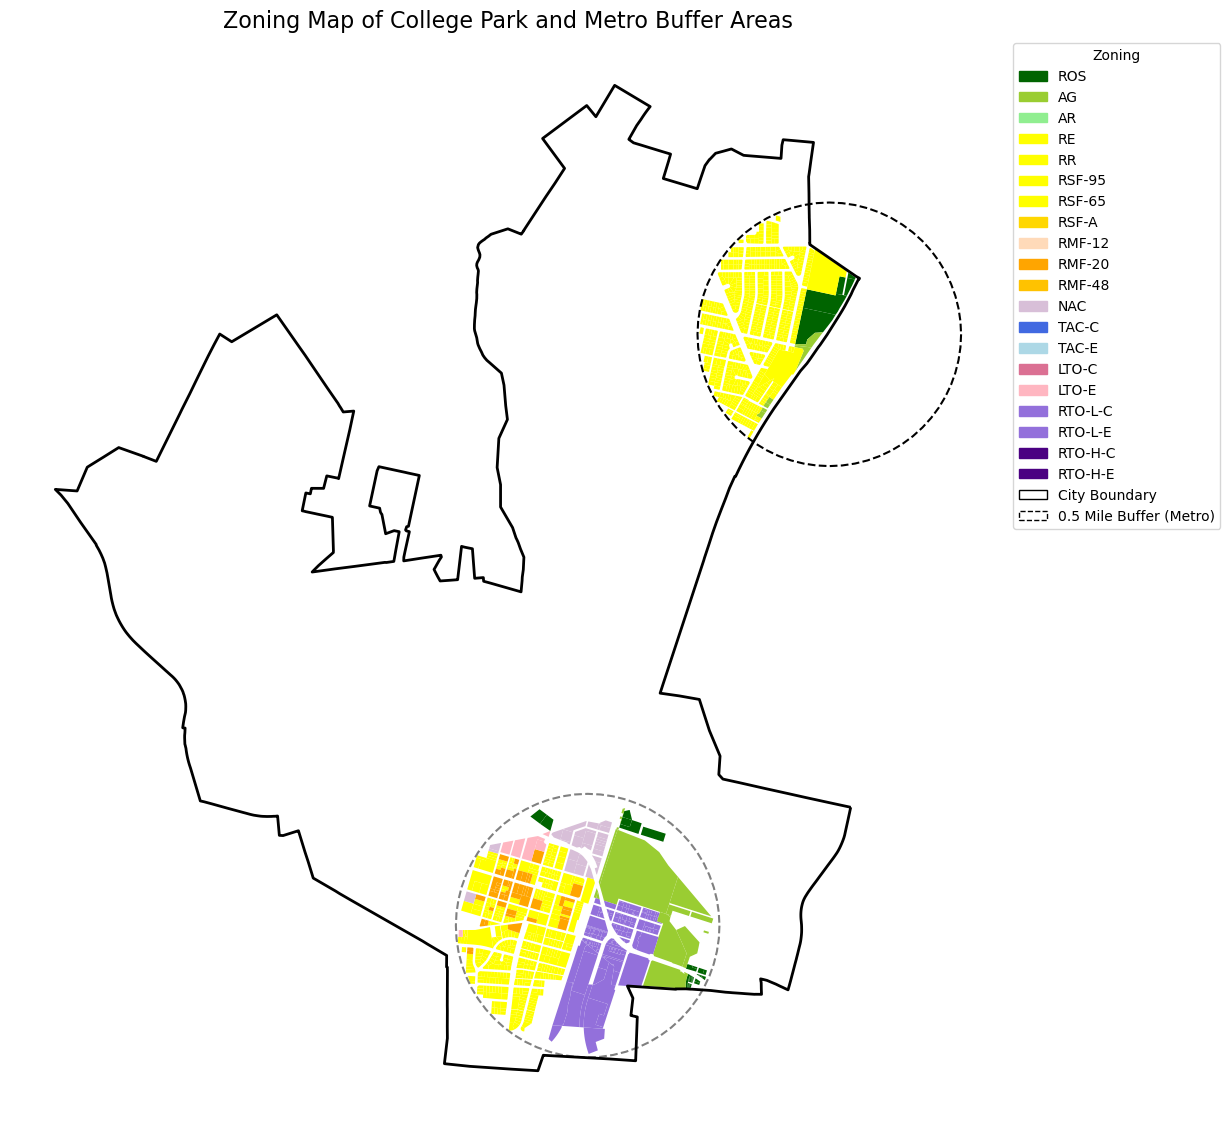

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- Prepare Data ---
# Combine all parcels of interest
zones_of_interest = pd.concat([greenbelt_cp, cpumd_cp])

# Map zone categories to colors
zone_color_map = {
    'ROS': 'darkgreen',
    'AG': 'yellowgreen',
    'AR': 'lightgreen',
    'RE': 'yellow',
    'RR': 'yellow',
    'RSF-95': 'yellow',
    'RSF-65': 'yellow',
    'RSF-A': '#FFD700',         # medium yellow
    'RMF-12': '#FFDAB9',        # light orange (peachpuff)
    'RMF-20': '#FFA500',        # medium orange
    'RMF-48': '#FFC200',        # gold/yellow-orange
    'NAC': '#D8BFD8',           # light purple
    'TAC-C': '#4169E1',         # medium blue
    'TAC-E': '#ADD8E6',         # light blue
    'LTO-C': '#DB7093',         # medium pink
    'LTO-E': '#FFB6C1',         # light pink
    'RTO-L-C': '#9370DB',       # medium purple
    'RTO-L-E': '#9370DB',       # medium purple
    'RTO-H-C': '#4B0082',       # dark purple
    'RTO-H-E': '#4B0082'        # dark purple
}

# Use ZONE_1 as the primary zone classification
zones_of_interest['zone_color'] = zones_of_interest['ZONE_1'].map(zone_color_map)

# Drop parcels without a valid zone color
zones_of_interest = zones_of_interest.dropna(subset=['zone_color'])

# --- Plotting ---
fig, ax = plt.subplots(figsize=(12, 12))

# Plot zoning by color
for zone, color in zone_color_map.items():
    subset = zones_of_interest[zones_of_interest['ZONE_1'] == zone]
    if not subset.empty:
        subset.plot(ax=ax, color=color, label=zone, linewidth=0)

# Add buffer outlines
gpd.GeoSeries(greenbelt_geom).boundary.plot(ax=ax, color='black', linestyle='--', linewidth=1.5, label='Greenbelt 0.5 mi buffer')
gpd.GeoSeries(cpumd_geom).boundary.plot(ax=ax, color='gray', linestyle='--', linewidth=1.5, label='College Park-U of Md 0.5 mi buffer')

# Add city boundary
gpd.GeoSeries(cp_geom).boundary.plot(ax=ax, color='black', linewidth=2, label='College Park city boundary')

# Title and legend
ax.set_title("Zoning Map of College Park and Metro Buffer Areas", fontsize=16)
ax.axis('off')

# Construct custom legend
legend_patches = [mpatches.Patch(color=color, label=zone) for zone, color in zone_color_map.items()]
legend_patches += [
    mpatches.Patch(edgecolor='black', facecolor='none', label='City Boundary'),
    mpatches.Patch(edgecolor='black', facecolor='none', linestyle='--', label='0.5 Mile Buffer (Metro)')
]
ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1), title='Zoning')

plt.tight_layout()
plt.show()